## 서울시 공공자전거의 rent장소에서 이용가능성 예측해 보기 

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
# 구글 드라이브 colab과 연동
#from google.colab import auth
#auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from sklearn.preprocessing import StandardScaler

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import os
import warnings

warnings.filterwarnings('ignore')

In [0]:
df = pd.read_pickle('/content/gdrive/My Drive/project/data.pkl')

## Data Summary
- Dataset size : data.shape
- Get a glimpse of data by printing few rows of it : data.head()
- type check : data.dtypes

In [20]:
df.shape

(6264839, 35)

In [21]:
df.head(2)

,number,rentplace,rentspot,returndate,returnNo,returnplace,returnspot,useTime,distance,dateymd,returnymd,rentday,renthour,rentweek,returnday,returnhour,returnweek,code,gender,age,useCount,temp,precipitation,wind(m/s),humidity,dtemp,finedust,ultrafinedust,time,구분,대여소번호,대여소명,위도,경도,거치대수
0,244,영등포삼환아파트 앞,5,2017-06-01 00:21:52,252,보라매역4번출구,2,21,5150,2017-06-01,2017-06-01,1,0,3,1,0,3,정기,M,30대,1.0,23.46087,0.0,3.230435,55.521739,30.647826,36.468333,17.66,11.5,영등포구,244,244. 영등포삼환아파트 앞,37.530079,126.905708,20
1,244,영등포삼환아파트 앞,3,2017-06-01 00:33:15,247,당산역 10번출구 앞,1,5,610,2017-06-01,2017-06-01,1,0,3,1,0,3,일일(회원),M,20대,1.0,23.46087,0.0,3.230435,55.521739,30.647826,36.468333,17.66,11.5,영등포구,244,244. 영등포삼환아파트 앞,37.530079,126.905708,20


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6264839 entries, 0 to 6264838
Data columns (total 35 columns):
number           int64
rentplace        object
rentspot         int64
returndate       datetime64[ns]
returnNo         object
returnplace      object
returnspot       int64
useTime          int64
distance         int64
dateymd          datetime64[ns]
returnymd        object
rentday          int64
renthour         int64
rentweek         int64
returnday        int64
returnhour       int64
returnweek       int64
code             category
gender           category
age              category
useCount         category
temp             float64
precipitation    float64
wind(m/s)        float64
humidity         float64
dtemp            float64
finedust         float64
ultrafinedust    float64
time             float64
구분               object
대여소번호            int64
대여소명             object
위도               float64
경도               float64
거치대수             int64
dtypes: category(4), datet

In [0]:
df.rename(columns={'거치대수':'parkingCount',
                  '구분': 'region',
                  '위도': 'lat',
                  '경도': 'long'}, inplace=True)

In [0]:
bike = df.copy()

In [25]:
bike.describe()

,number,rentspot,returnspot,useTime,distance,rentday,renthour,rentweek,returnday,returnhour,returnweek,temp,precipitation,wind(m/s),humidity,dtemp,finedust,ultrafinedust,time,대여소번호,lat,long,parkingCount
count,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06,6.264839e+06
mean,8.717966e+02,7.039303e+00,7.004295e+00,2.883373e+01,3.992434e+03,1.628875e+01,1.450092e+01,2.937011e+00,1.628262e+01,1.458725e+01,2.939535e+00,1.655843e+01,2.220911e-01,1.973558e+00,5.817782e+01,1.818440e+01,3.928301e+01,2.216090e+01,1.150505e+01,8.717966e+02,3.754858e+01,1.269833e+02,1.416894e+01
std,7.365886e+02,5.336311e+00,5.351659e+00,3.073484e+01,6.098035e+03,8.890960e+00,6.039109e+00,1.972017e+00,8.892149e+00,6.303285e+00,1.973656e+00,8.538792e+00,8.435628e-01,6.029628e-01,1.339419e+01,9.488972e+00,2.081872e+01,1.345949e+01,1.501961e-01,7.365886e+02,3.968722e-02,7.599722e-02,6.238363e+00
min,1.010000e+02,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.473750e+01,0.000000e+00,7.583333e-01,2.225000e+01,-9.170833e+00,6.288333e+00,3.950000e+00,1.113043e+01,1.010000e+02,3.744334e+01,1.267986e+02,5.000000e+00
25%,2.680000e+02,3.000000e+00,3.000000e+00,8.000000e+00,1.170000e+03,9.000000e+00,1.000000e+01,1.000000e+00,9.000000e+00,1.000000e+01,1.000000e+00,1.298750e+01,0.000000e+00,1.537500e+00,4.912500e+01,1.308333e+01,2.372333e+01,1.191167e+01,1.150000e+01,2.680000e+02,3.752136e+01,1.269200e+02,1.000000e+01
50%,5.710000e+02,6.000000e+00,6.000000e+00,1.800000e+01,2.280000e+03,1.600000e+01,1.600000e+01,3.000000e+00,1.600000e+01,1.600000e+01,3.000000e+00,1.774167e+01,0.000000e+00,1.850000e+00,5.845833e+01,1.997500e+01,3.611167e+01,1.999667e+01,1.150000e+01,5.710000e+02,3.754990e+01,1.269775e+02,1.200000e+01
75%,1.313000e+03,1.000000e+01,1.000000e+01,4.000000e+01,4.740000e+03,2.400000e+01,1.900000e+01,5.000000e+00,2.400000e+01,1.900000e+01,5.000000e+00,2.264583e+01,0.000000e+00,2.291667e+00,6.700000e+01,2.557083e+01,5.080333e+01,2.888167e+01,1.150000e+01,1.313000e+03,3.757258e+01,1.270491e+02,2.000000e+01
max,3.524000e+03,4.100000e+01,4.100000e+01,3.864000e+03,2.559900e+05,3.100000e+01,2.300000e+01,6.000000e+00,3.100000e+01,2.300000e+01,6.000000e+00,3.133333e+01,1.213636e+01,4.000000e+00,9.633333e+01,3.449583e+01,1.167617e+02,9.472000e+01,1.563636e+01,3.524000e+03,3.768972e+01,1.271803e+02,4.000000e+01


In [32]:
bike.tail(2)

,number,rentplace,rentspot,returndate,returnNo,returnplace,returnspot,useTime,distance,dateymd,returnymd,rentday,renthour,rentweek,returnday,returnhour,returnweek,code,gender,age,useCount,temp,precipitation,wind(m/s),humidity,dtemp,finedust,ultrafinedust,time,region,대여소번호,대여소명,lat,long,parkingCount
6264837,946,독바위역,6,2018-05-31 19:08:05,926,불광역 8번출구,1,5,1060,2018-05-31,2018-05-31,31,19,3,31,19,3,0,0,0,0.0,15.8,0.0,1.6,82.0,15.3,41.433043,23.593043,11.652174,은평구,946,독바위역,37.618439,126.932884,10
6264838,946,독바위역,1,2018-05-31 23:13:36,946,독바위역,1,24,850,2018-05-31,2018-05-31,31,22,3,31,23,3,0,0,0,0.0,15.8,0.0,1.6,82.0,15.3,41.433043,23.593043,11.652174,은평구,946,독바위역,37.618439,126.932884,10


In [27]:
bike.columns

Index(['number', 'rentplace', 'rentspot', 'returndate', 'returnNo',
       'returnplace', 'returnspot', 'useTime', 'distance', 'dateymd',
       'returnymd', 'rentday', 'renthour', 'rentweek', 'returnday',
       'returnhour', 'returnweek', 'code', 'gender', 'age', 'useCount', 'temp',
       'precipitation', 'wind(m/s)', 'humidity', 'dtemp', 'finedust',
       'ultrafinedust', 'time', 'region', '대여소번호', '대여소명', 'lat', 'long',
       'parkingCount'],
      dtype='object')

In [0]:
import datetime as dt

In [0]:

bike['minute'] = bike.returndate.dt.minute
bike['hour'] = bike.returndate.dt.hour
bike['year'] = bike.returndate.dt.year
bike['month']= bike.returndate.dt.month
bike['day'] = bike.returndate.dt.day


In [30]:
bike[['minute']]

,minute
0,21
1,33
2,33
3,42
4,10
...,...
6264834,35
6264835,31
6264836,34
6264837,8


In [0]:

# numeric value로 바꿔줌. 
bike['age'] = bike.age.map({'0' : 0,
                                    '~10대':1,
                                    '20대':2,
                                    '30대':3,
                                    '40대':4,
                                    '50대':5,
                                    '60대':6,
                                    '70대~':7}).astype(float)
bike['age'].fillna(0,inplace = True)
bike['age'] = bike['age'].astype('int64')


bike['gender'] = bike.gender.map({'F':1, 'M':2}).astype(float)
bike['gender'].fillna(0,inplace = True)
bike['gender'] = bike['gender'].astype('int64')

bike['code'] = bike.code.map({'0' : 0,
                                    '정기':1,
                                    '정기권':1,
                                    '정기(2시간권)':1,
                                    '일일권':2,
                                    '일일(2시간권)':2,
                                    '일일(비회원)':2,
                                    '일일권(비회원)':2,
                                    '단체권':3,
                                    '단체':3}).astype(float)
bike['code'].fillna(0,inplace = True)
bike['code'] = bike['code'].astype('int64')

아래의 범주화는 사용하지 않는것이 더 나은 결과를 보였고, 후에 인코딩 과정을 거치므로 내 임의로 범주화해주는 것이 가짓수를 줄여줄 수는 있으나 좋은 방법이라고 보긴 힘들다. 

In [0]:
# finedust

bike.loc[bike['finedust'] <= 30, 'finedust'] = 0
bike.loc[(bike['finedust']>30) & (bike['finedust']<= 50),'finedust'] = 1
bike.loc[(bike['finedust']>50) & (bike['finedust']<= 100),'finedust'] = 2
bike.loc[(bike['finedust']>100) ,'finedust'] = 3
bike['finedust'] = bike['finedust'].astype(int)

In [0]:
# temp data
bike.loc[bike['temp'] <=0, 'temp']=0
bike.loc[(bike['temp'] >0 )&(bike['temp']<=12) , 'temp']=1
bike.loc[(bike['temp'] >12 )&(bike['temp']<=18) , 'temp']=2
bike.loc[(bike['temp'] >18 )&(bike['temp']<=22) , 'temp']=3
bike.loc[(bike['temp'] >22 )&(bike['temp']<=28) , 'temp']=4
bike.loc[bike['temp'] >28, 'temp']=5
bike['temp'] = bike['temp'].astype(int)

In [0]:
# 습도 
bike.loc[(bike['humidity']<= 58), 'humidity'] = 0
bike.loc[(bike['humidity']>58),'humidity'] = 1
bike['humidity'].astype(int)

In [0]:
# number에 str 데이터 전처리
# 마지막 누락 번호로 이어 붙여 주자. 
bike['number'] = bike['number'].replace('위트콤','301') #종로구
bike['number'] = bike['number'].replace('위트콤공장','301') #종로구
bike['number'] = bike['number'].replace('중랑센터','301') # 종로구
bike['number'] = bike['number'].replace('중랑정비팀test 1005','301') # 종로구
bike['number'] = bike['number'].replace('상암센터 정비실','301')  #마포구

In [0]:
# 필요없는 칼럼 드랍
X = bike.drop(['dtemp','time'], axis=1)

모델의 라벨은 이용가능성으로 두고 테스트를 해봄. 

In [0]:
# 자전거 렌트스팟 갯수로 이용가능성을 수치화 한다. 

X.loc[X['rentspot']< 2, 'availablity' ] = 0
X.loc[X['rentspot']>=2, 'availablity'] = 1

In [0]:
# 자전거 리턴스팟 갯수로 이용가능성을 수치화 한다. 

X.loc[X['returnspot']< 2, 'availablity' ] = 0
X.loc[X['returnspot']>=2, 'availablity'] = 1

만약 재배치 문제를 고려한다면 이보다는 A에서 B로 이동하는 거점에 한해서 예상 vehicle의 갯수를 구해야 더 정확하다. 

< Gorege and Xia 재배치 문제 논문에 나와있는 식을 적용한 방법이 나와있다. >
rt = unit time t까지 이동하는 
Pi = 유저가 자전거를 i거치소에서 발견하지 못할 페널티 
cm = per unit time 재배치와 같은 maintenance Count

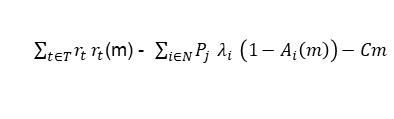


In [0]:
X['total'] = (X['rentspot'] / X['parkingCount'])
#'useCount','gender','code','finedust','ultrafinedust','temp','humidity','rentweek',
#'age','distance','parkingCount','rentspot','returnspot'

In [0]:
# 마포구만
X= X.loc[ X['region']=='마포구'] #(X['region']=='종로구')|

In [0]:
# 종로구만
X= X.loc[X['region']=='종로구'] 

In [0]:
X['availablity'].describe()

count    499173.000000
mean          0.856691
std           0.350388
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: availablity, dtype: float64

### availability에 대해서 정적시스템에 관해서만 가정을 일단 해봄
- 3미만 : 이용임계, 0으로 매치 
- 3이상 ~ : 이용가능, 1으로 매치 
위와 같이 하게되면 재배치에 관해서는 논하기 어렵다. 잔여 개수에 한해서 적정 재배치 수량을 조절해 주어야 하는데 그게 필요하다. 

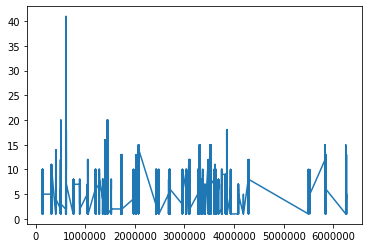

In [0]:
plt.plot(X['rentspot'])

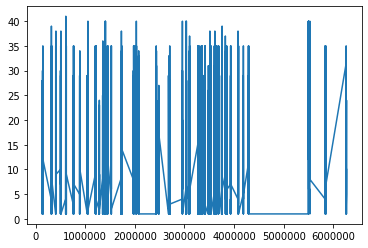

In [70]:
plt.plot(X['returnspot'])

In [0]:
X['total_r'] = X['returnspot'] / X['parkingCount'] 

In [0]:
## 여기서 max값이 41과 같은 곳이 있지만 이상치로 분류하진 않았다. 실제 저렇게 잔여개수가 있을수도 있기 때문이다. 

In [0]:
X['rentspot'].describe()

count    499173.000000
mean          5.569690
std           3.657421
min           1.000000
25%           3.000000
50%           5.000000
75%           8.000000
max          41.000000
Name: rentspot, dtype: float64

In [55]:
X['returnspot'].describe()

count    499173.000000
mean          5.804651
std           4.335781
min           1.000000
25%           2.000000
50%           5.000000
75%           8.000000
max          41.000000
Name: returnspot, dtype: float64

In [0]:
X['total'].describe()

count    6.264839e+06
mean     5.090442e-01
std      3.001813e-01
min      0.000000e+00
25%      2.500000e-01
50%      5.000000e-01
75%      7.894737e-01
max      2.562500e+00
Name: total, dtype: float64

In [0]:
X.columns

Index(['number', 'rentplace', 'rentspot', 'returndate', 'returnNo',
       'returnplace', 'returnspot', 'useTime', 'distance', 'dateymd',
       'returnymd', 'rentday', 'renthour', 'rentweek', 'returnday',
       'returnhour', 'returnweek', 'code', 'gender', 'age', 'useCount', 'temp',
       'precipitation', 'wind(m/s)', 'humidity', 'finedust', 'ultrafinedust',
       'region', 'lat', 'long', 'parkingCount', 'minute', 'year', 'month',
       'day', 'total'],
      dtype='object')

In [0]:
# feature 변수를 따로 선언하자. 

# 1. 온습도
feature1 = X[['number','rentweek','renthour','temp','humidity','long','lat','rentspot']]

# 2. 먼지 
feature2 = X[['number','rentweek','finedust','ultrafinedust','long','lat','rentspot']]

# 3. 온습도 + 이용자 특성
feature3 = X[['number','rentweek','humidity','temp','code','age','long','lat','rentspot']]

# 4. 온습도 + 먼지 
feature4 = X[['number','rentweek','humidity','temp','finedust','ultrafinedust','long','lat','rentspot']]


In [14]:
import tensorflow as tf
#from keras import backend as K
print(tf.__version__)

2.0.0-dev20191002


## 텐서플로우 패키지 참고 
- https://datascienceschool.net/view-notebook/5cbab09d777841f591a67928d7043f51/

In [0]:
##'finedust',,'number','humidity','gender','age' : 변수를 줄이는것이 문제가 아니고 예측의 범위를 줄이는것이 중요할 것 같다. 

## 종로구에 한정해서 트레인 테스트 셋을 만들어보자. 

사실 이전에는 관련이 없어보이는 여러 변수들을 포함시켜 새로운 분류를 해보고자 했지만, 라벨값이 이용가능성이라고 보았을때, 성별이나 나이는 중요하지 않을것 같다. 그리고 이용권 구분은 정기권으로 빌리거나 그러지 않았을때 과정을 살펴보면 빌릴수있는 시간텀이 있기 때문에 의미있는 결과가 나올 것이라 예상했다. 
정기권이 이미 등록되어 있는 정보를 가지고 빌리는 것이기 때문에 더 빠를것이라 가정한다. 

In [0]:
xy = X.groupby(['year','month','day','renthour','minute','temp', 'number','finedust','humidity','code'])['rentspot'].agg({
    'rentspot' : 'mean'}).reset_index()

In [0]:
# Availability 로 label
xy = X.groupby(['year','month','day','renthour','minute','temp','number', 'finedust','humidity','code'])['availablity'].agg({
    'availablity' : 'mean'}).reset_index()

In [0]:
# Availability 로 label
xy = X.groupby(['year','month','day','hour','minute','temp','number', 'finedust','humidity','code'])['availablity'].agg({
    'availablity' : 'mean'}).reset_index()

In [72]:
xy.shape

(469118, 11)

In [39]:
xy.describe()

,temp,number,finedust,humidity,code,rentspot
count,497315.000000,497315.000000,497315.000000,497315.000000,497315.000000,497315.000000
mean,16.507593,340.829299,38.846749,58.580661,0.409968,5.569942
std,9.229823,29.438467,20.105848,13.387454,0.524612,3.656780
min,-14.737500,301.000000,6.288333,22.250000,0.000000,1.000000
25%,12.258333,316.000000,23.855000,49.250000,0.000000,3.000000
50%,18.062500,340.000000,36.005000,58.791667,0.000000,5.000000
75%,23.170833,358.000000,49.873333,67.500000,1.000000,8.000000
max,31.333333,451.000000,116.761667,96.333333,3.000000,41.000000


In [0]:
xy.head(50)

In [0]:
xy.dtypes

year          int64
month         int64
day           int64
renthour      int64
minute        int64
rentweek      int64
temp        float64
finedust    float64
humidity    float64
code          int64
gender        int64
age           int64
number        int64
rentspot    float64
dtype: object

In [0]:
pip install --upgrade pingouin

     |████████████████████████████████| 215kB 4.9MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.0-cp36-none-any.whl size=211662 sha256=30f92e6b2858b885ab061b965d973115480eae88b285a8a675be8ce833688a02
  Stored in directory: /root/.cache/pip/wheels/63/77/53/3b0312ca8a50325c6995cc9a205784b64f8ba08872f91375b9
Successfully built pingouin


In [0]:
import pingouin as pg
pg.corr(x = xy['finedust'], y = xy['availablity'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,252701,0.004,"[0.0, 0.01]",0.0,0.0,0.028476,0.027,0.591


Text(0.5, 1, 'correlation matrix')

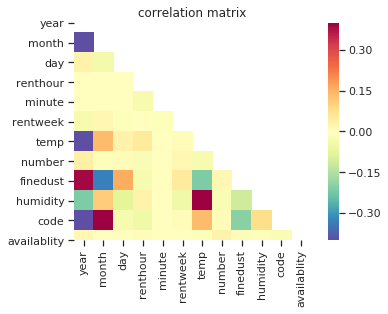

In [0]:
corrs = xy.corr().round(2)
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap = 'Spectral_r', mask = mask, square = True, vmin = -.4, vmax = .4)
plt.title('correlation matrix')

In [0]:
xy.rcorr(stars = False)

,year,month,day,renthour,minute,rentweek,temp,number,finedust,humidity,code,availablity
year,-,0.,0.000,0.002,0.828,0.000,0.,0.000,0.,0.,0.,0.000
month,-0.824,-,0.000,0.06,0.315,0.000,0.,0.000,0.,0.,0.,0.002
day,0.028,-0.043,-,0.015,0.215,0.000,0.000,0.000,0.,0.,0.000,0.344
renthour,-0.005,-0.003,-0.004,-,0.000,0.673,0.000,0.000,0.000,0.000,0.000,0.000
minute,0.0,-0.001,-0.002,-0.03,-,0.000,0.302,0.442,0.981,0.798,0.022,0.453
rentweek,-0.026,0.021,-0.009,-0.001,-0.005,-,0.000,0.000,0.000,0.000,0.000,0.182
temp,-0.409,0.142,0.03,0.046,-0.002,0.009,-,0.000,0.,0.,0.,0.000
number,0.04,-0.006,0.006,-0.019,0.001,0.023,-0.031,-,0.000,0.000,0.000,0.000
finedust,0.385,-0.33,0.161,-0.026,0.0,0.046,-0.215,0.016,-,0.,0.,0.000
humidity,-0.205,0.109,-0.078,0.025,-0.0,-0.048,0.431,-0.022,-0.106,-,0.,0.000


In [0]:
xy[['finedust', 'temp', 'humidity','code','number']].corr()

,finedust,temp,humidity,code,number
finedust,1.000000,-0.214762,-0.106304,-0.201194,0.015503
temp,-0.214762,1.000000,0.431012,0.139028,-0.030971
humidity,-0.106304,0.431012,1.000000,0.084308,-0.022039
code,-0.201194,0.139028,0.084308,1.000000,0.005383
number,0.015503,-0.030971,-0.022039,0.005383,1.000000


In [0]:
xy['number']= xy.number.astype('str')

## 미래의 특정 number의 rentspot을 예측 /보류 과정이 꼬인듯함. 
- target_number = '147' 
- target_name = ['rentspot'] / 신호를 예측하는 의미로 다수의 신호를 넣어주어도 된다. 

In [0]:
# 종로구의 147번 거치소의 남아있는 자전거 갯수를 예측 , 미래의 7일을 예측
target_number ='341'
target_name = ['rentspot']

# 24시간의 데이터를 교차이동
shift_days = 1
shift_steps = shift_days *24 # number of hours

# 음수 교차이동임을 확인하고, 새 데이터 프레임을 만든다.  
df_target = xy[target_number][target_name].shift(-shift_steps)

## Scaling의 종류 
- Scikit -learn에서 제공하는 다양한 종류의 스케일러 
1. StandardScaler : 기본 스케일, 평균과 표준편차 사용
2. MinMaxScaler : 최대/최소값이 각각 1, 0이 되도록 스케일링
3. MaxAbsSaler : 최대절대값과 0이 각각 1, 0이 되도록 스케일링
4. RobustScaler : 중앙값(median)과 IQR(interquatile range) 사용, 아웃라이어의 영향을 최소화 


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [0]:
# 데이터 정규화
#xy = X [[ 'number','temp','renthour','minute','month','year','rentweek','finedust','humidity','gender','age','code', 'availablity']] # 'humidity','gender','age'
#xy[['year','month','day','renthour','minute','rentweek','temp', 'finedust','humidity','code','gender','age','number','rentspot']]
xy = StandardScaler().fit_transform(xy)
x = xy[:,:-1]
y = xy[:,-1]

#x.shape
#y.shape

In [0]:
xy = MinMaxScaler().fit_transform(xy)
x = xy[:,:-1]
y = xy[:,-1]


In [0]:
# 위과정에서 x, y를 나누었다.
#x = xy[['year','month','day','renthour','minute','rentweek','temp','number', 'finedust','humidity','code']]
#y = xy[['availability']]

In [0]:
x.shape

(469576, 10)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
RANDOM_SEED = 42
TEST_SPLIT = 0.2

train_x, train_y,test_x, test_y = train_test_split(x,y, test_size = TEST_SPLIT, random_state = RANDOM_SEED)

In [0]:
# train/test split _ 시퀀스 없이 그냥 데이터 셋 나누기 
train_size = int(len(y)*0.8)
test_size = len(y)-train_size
#test_size = len(y)*0.1

train_x, test_x = np.array(x[0:train_size]), np.array(x[train_size:len(x)])
train_y, test_y = np.array(y[0:train_size]), np.array(y[train_size:len(y)])
train_y = np.reshape(train_y, (-1,1))

In [0]:

#test_x = np.reshape(test_x, (-1,1))
test_y = np.reshape(test_y, (-1,1))

In [0]:
test_x.shape

(93916, 11)

In [0]:
test_y.shape

(93916, 1)

In [0]:
len(train_x.shape)

2

In [0]:
train_y.shape

(375660, 1)

In [0]:
len(test_x.shape)

2

In [0]:
len(test_y.shape)

2

## Lgbm 

In [0]:
# 80% 는 학습에 사용하고 20%는 예측에 사용합니다.
split_index = round(X.shape[0] * 0.8)
split_index

5011871

In [0]:
split_index = round(xy.shape[0] * 0.8)
split_index

375661

In [0]:
# 데이터를 학습과 예측에 사용할 용도로 나눕니다.
# 파이썬의 슬라이싱 기능을 활용해서 나눕니다.
train = X[:split_index].copy()
test = X[split_index:].copy()

print("학습 데이터 크기", train.shape)
print("테스트 데이터 크기", test.shape)

학습 데이터 크기 (5011871, 38)
테스트 데이터 크기 (1252968, 38)


In [0]:
train = xy[:split_index].copy()
test = xy[split_index:].copy()

print("학습 데이터 크기", train.shape)
print("테스트 데이터 크기", test.shape)

학습 데이터 크기 (375661, 11)
테스트 데이터 크기 (93915, 11)


In [0]:
# 학습과 예측에 사용할 컬럼
# 이용거리를 피처에 추가하고 제외해 본다.
feature_columns = ['year','month','day','renthour','minute','temp', 'finedust','humidity','code','number']
feature_columns

['year',
 'month',
 'day',
 'renthour',
 'minute',
 'temp',
 'finedust',
 'humidity',
 'code',
 'number']

In [0]:
#label_column = "rentspot"
label_column = "availablity"
label_column

'availablity'

In [0]:
# 학습, 예측에 사용할 컬럼만 추출
train_x = train[feature_columns].copy()
test_x = test[feature_columns].copy()

print("학습에 사용할 피처 크기", train_x.shape)
print("예측에 사용할 피처 크기", test_x.shape)

학습에 사용할 피처 크기 (5011871, 10)
예측에 사용할 피처 크기 (1252968, 10)


In [0]:
train_y = train[label_column]

In [0]:
test_y = test[label_column]

In [0]:
import lightgbm as lgbm

def runLGBM(train_x, train_y, test_x, seed_val=42):
    params = {
        'boosting_type': 'gbdt', 'objective': 'regression', 'nthread': -1, 'verbose': 0,
        'num_leaves': 31, 'learning_rate': 0.05, 'max_depth': -1,
        'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 
        'reg_alpha': 1, 'reg_lambda': 0.001, 'metric': 'rmse',
        'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}
    
    pred_test_y = np.zeros(test_x.shape[0]) # 속도를 위해 초기화
    
    train_set = lgbm.Dataset(train_x, train_y, silent=True)
    lgb_eval = lgbm.Dataset(train_x, train_y, reference=train_set)
        
    model = lgbm.train(params, train_set=train_set, num_boost_round=1000,valid_sets=lgb_eval, early_stopping_rounds=5)
    pred_test_y = model.predict(test_x, num_iteration = model.best_iteration)
        
    return pred_test_y , model

In [0]:
y_predict_lgbm, model = runLGBM(train_x, train_y, test_x, seed_val=42)

[1]	valid_0's rmse: 0.318441
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.318367
[3]	valid_0's rmse: 0.318358
[4]	valid_0's rmse: 0.318282
[5]	valid_0's rmse: 0.318268
[6]	valid_0's rmse: 0.318196
[7]	valid_0's rmse: 0.318139
[8]	valid_0's rmse: 0.318078
[9]	valid_0's rmse: 0.318028
[10]	valid_0's rmse: 0.317982
[11]	valid_0's rmse: 0.317971
[12]	valid_0's rmse: 0.317923
[13]	valid_0's rmse: 0.317887
[14]	valid_0's rmse: 0.317881
[15]	valid_0's rmse: 0.317874
[16]	valid_0's rmse: 0.317832
[17]	valid_0's rmse: 0.317824
[18]	valid_0's rmse: 0.317795
[19]	valid_0's rmse: 0.31779
[20]	valid_0's rmse: 0.317752
[21]	valid_0's rmse: 0.317723
[22]	valid_0's rmse: 0.317696
[23]	valid_0's rmse: 0.317662
[24]	valid_0's rmse: 0.31763
[25]	valid_0's rmse: 0.317607
[26]	valid_0's rmse: 0.317573
[27]	valid_0's rmse: 0.317555
[28]	valid_0's rmse: 0.317532
[29]	valid_0's rmse: 0.317514
[30]	valid_0's rmse: 0.31751
[31]	valid_0's rmse: 0.317491
[32]	valid_0's rmse: 

In [0]:
# 예측값을 정답값과 비교해 주기 위해 y데이터 프레임에 담아준다. 
test["rentspot(lgbm)"] = y_predict_lgbm

## lgbm 평가 

In [0]:
# 성능 평가 비교를 위해 score 변수를 만든다.
score = {}
score["LGBM"] = {}

In [0]:
# MAE - Mean Absolute Error
# 실제값과 예측값의 차이에 절대값을 씌운 후 평균을 구한다.
score["LGBM"]["MAE"] = abs(y_predict_lgbm - test_y).mean()
score["LGBM"]["MAE"]

0.2021823360563042

In [0]:
# RMSE - Root Mean Square Error
# 실제값과 예측값의 차이에 제곱을 해서 음수를 양수로 만들고 평균값을 구한 후 루트를 씌워준다.
# => 과대평가 된 항목보다 과소평가된 항목에 패널티를 주기 위해 
# 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미다.
score["LGBM"]["RMSE"] = np.sqrt(
    ((y_predict_lgbm - test_y)**2).mean()
)
score["LGBM"]["RMSE"]

0.3211882584226215

In [0]:
score

{'LGBM': {'MAE': 0.2021823360563042, 'RMSE': 0.3211882584226215}}

## RandomForest regression

In [0]:
from sklearn.ensemble import RandomForestRegressor
# 모델 선언
rf = RandomForestRegressor()
# 학습
rf.fit(train_x, train_y)
# 예측
rf_predict = rf.predict(test_x)
print(rf_predict)
#print('rmsle value for random forest: ', rmsle(np.exp(np.log1p(test_y)), np.exp(rf_predict), False))

test['predict_spot(rf)'] = rf_predict

[0.8 0.8 0.8 ... 0.8 0.7 0.8]


In [0]:
# 평가 
score['rf']= {}

# RMSE - Root mean square error
score['rf']['RMSE'] = np.sqrt(
    ((rf_predict - test_y)**2).mean()
)
score['rf']['RMSE']

0.35684573475697695

## Linear Regression
use RMSLE

In [0]:

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

위의 rmsle score를 함수로 정의해봄. => 자주 사용할 수도 있으므로. 

In [0]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다. 
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다. 
    calc = (log1 - log2) ** 2
    # 평균을 내고 다시 루트를 씌운다. 
    return np.sqrt(np.mean(calc))

In [0]:

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits= 10, shuffle = True, random_state = 0)

In [0]:

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = train_x,y = np.log1p(train_y))

# Make predictions
preds = lModel.predict(X= test_x)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(test_y)),np.exp(preds),False))

RMSLE Value For Linear Regression In Validation:  0.13012264180506872


In [0]:
test['linear_rentspot'] = preds
score['linear'] = {}
score['linear']['RMSE']= np.sqrt(
    ((preds - test_y)**2).mean()
)
score["linear"]["RMSE"]

0.4175755926104325

현 데이터는 비선형 적이므로 모델이 선형 분류냐 랜덤 포레스트와 같은 경우 이전 LGBM모델에 비해서 오차가 커지는 것을 확인 할 수 있다. 

In [0]:
test.head()

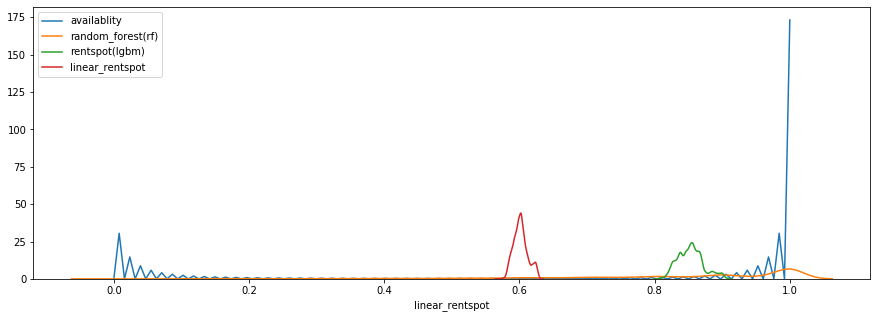

In [0]:
plt.figure(figsize=(15, 5))
sns.distplot(test[label_column], label=label_column, hist=False)
sns.distplot(test["predict_spot(rf)"], label="random_forest(rf)", hist=False)
sns.distplot(test["rentspot(lgbm)"], label="rentspot(lgbm)", hist=False)
sns.distplot(test["linear_rentspot"], label="linear_rentspot", hist=False)

[Text(0.5, 1.0, 'Test Set Distribution')]

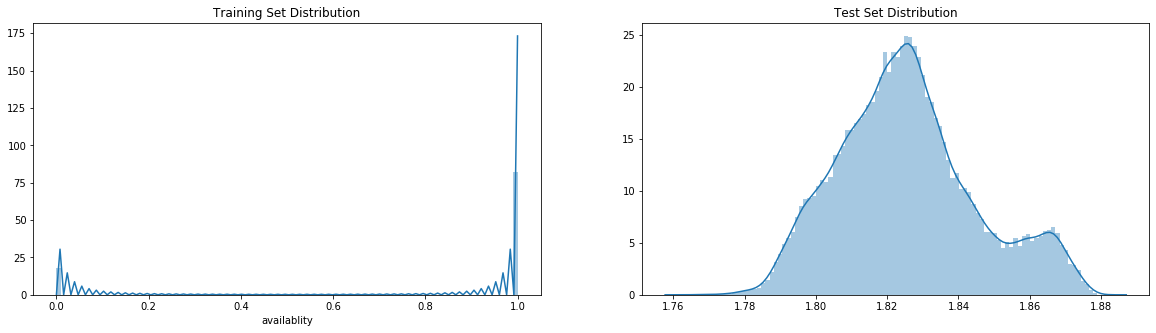

In [0]:
import seaborn as sn
predsTest = lModel.predict(X=test_x)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(test_y,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

## Regularization Model - Ridge

In [0]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

{'alpha': 800, 'max_iter': 3000}
-0.13814663942625166
rmsle Value For ridge regression: 0.1565266390520636


KeyError: ignored

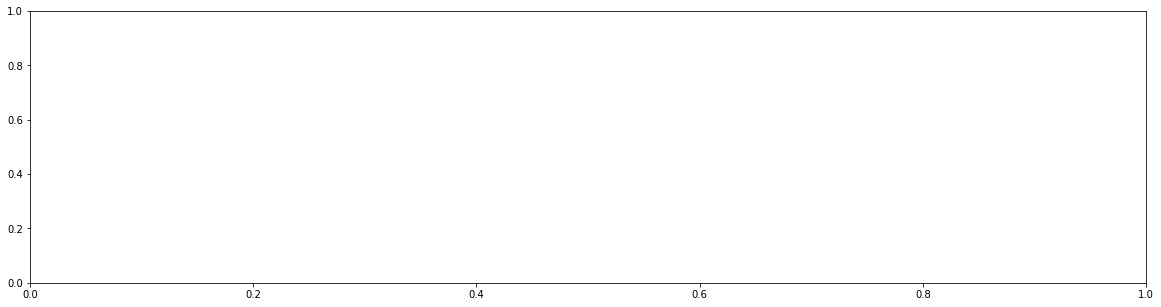

In [0]:


ridge_m_= Ridge()
ridge_params_ = {'max_iter':[3000], 'alpha':[0.01, 0.05,0.1, 1, 2, 3, 4, 10, 30, 100, 200, 400, 800]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better= False)
gride_ridge_m = GridSearchCV(ridge_m_,
                             ridge_params_,
                             scoring = rmsle_scorer,
                             cv = 5)
gride_ridge_m.fit(X= train_x, y= np.log1p(train_y))
preds = gride_ridge_m.predict(X = test_x)
print(gride_ridge_m.best_params_)
print(gride_ridge_m.best_score_)
print('rmsle Value For ridge regression:', rmsle(np.exp(np.log1p(test_y)), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
df = pd.DataFrame(gride_ridge_m.cv_results_) #cv_results_,  grid_scores_

df['alpha'] = df['parameters'].apply(lambda x : x['alpha'])
df['rmsle'] = df['mean_validation_score'].apply(lambda x : -x)
sn.pointplot(data=df, x='alpha', y = 'rmsle', ax=ax)
gride_ridge_m.score(train_x, train_y), gride_ridge_m.best_score_
# parameter name이 변경되어 그래프 그릴때 에러가 뜬다. 
# ridge regulation모델을 사용하면 rmsle가 조절될 것이라 생각했는데 훨씬더 낮아졌다. 

In [0]:
test_x = np.reshape(test_x, (-1,1))

In [0]:
test_x.shape

(99835, 11)

In [0]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

tf.random.set_seed(777)
X = tf.placeholder(tf.float32, shape=(None, 11))
Y = tf.placeholder(tf.float32, shape = (None,1 ))

W = tf.Variable(tf.random_normal([11,1]), name = 'weight')
b = tf.Variable(tf.random_normal([1]), name='bias')

TypeError: ignored

In [0]:
# 가설함수 
hypothesis = tf.sigmoid(tf.matmul(X,W)+b)

loss = -tf.reduce_mean(Y*tf.log(hypothesis)+ (1-Y)*tf.log(1-hypothesis))
train = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(loss)

predict = tf.cast(hypothesis >0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predict, Y), dtype=tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(5000):
        loss_val, _ = sess.run([loss, train], feed_dict={X:train_x, Y:train_y})

        if step %200 ==0:
            print(step, loss_val)

    h, p, a = sess.run([hypothesis, predict, accuracy], feed_dict={X:test_x, Y:test_y})
    print("\nHypothesis : ", h, "\nPredict : ", p, "\nAccuracy: ", a)

0 1.4298147
200 1.4007341
400 1.3723304
600 1.3446028
800 1.3175483
1000 1.2911642
1200 1.265446
1400 1.2403892
1600 1.2159884
1800 1.1922367
2000 1.1691277
2200 1.1466532
2400 1.1248052
2600 1.1035758
2800 1.0829542
3000 1.0629307
3200 1.0434961
3400 1.024639
3600 1.0063483
3800 0.9886127
4000 0.97142065
4200 0.95476055
4400 0.9386199
4600 0.92298645
4800 0.90784883

Hypothesis :  [[0.8254406 ]
 [0.82220507]
 [0.819583  ]
 ...
 [0.51862305]
 [0.5163965 ]
 [0.508599  ]] 
Predict :  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]] 
Accuracy:  0.70824915


In [0]:
y['multilinear_rentspot'] = p
score['multilinear_rentspot'] = {}
score['multilinear_rentspot']['RMSE']= np.sqrt(
    ((predict - test_y)**2).mean()
)
score["multilinear_rentspot"]["RMSE"]

IndexError: ignored

## RNN -tensorflow 2.0버전으로 수정필요
- 우리는 왜 RMSE를 사용할까?
: 보통 고양이 개 타겟값을 예측하는 분류모델에서는 정확도의 의미가 있지만, 
수치형의 모델에서는 정확도를 예측하는 것이 조금 애매하다. 그래서 regression문제 에서는 크기의존적 에러값을 중요시한다. 

- RMSE 는 함수로도 표현할 수 있고, regression loss function으로 
: model.compile(loss = 'mean_squared_error', optimizer = 'adam') 처럼 표현할 수 있다. 

- 단점:!! 크기 의존적이므로 대상의 크기에 영향을 받는다. 

RNN 입력 데이터  = (자료의 수, timestep(순서열의 크기), input_dim(벡터의 크기))

### preprocessing

In [16]:
split_index = round(xy.shape[0] * 0.8)
split_index

train = xy[:split_index].copy()
test = xy[split_index:].copy()

print("학습 데이터 크기", train.shape)
print("테스트 데이터 크기", test.shape)


학습 데이터 크기 (375294, 11)
테스트 데이터 크기 (93824, 11)


# datetmd 각각 개별 컬럼으로 구성

In [0]:
from sklearn.preprocessing import RobustScaler

f_columns = ['year','month','day','hour','minute','temp', 'finedust','humidity','code','number']

f_transformer = RobustScaler()
a_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
a_transformer = a_transformer.fit(train[['availablity']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['availablity'] = a_transformer.transform(train[['availablity']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['availablity'] = a_transformer.transform(test[['availablity']])

In [0]:
#rentsp을 타겟값으로 변경
from sklearn.preprocessing import RobustScaler

f_columns = ['year','month','day','renthour','minute','temp', 'finedust','humidity','code','number']

f_transformer = RobustScaler()
a_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
a_transformer = a_transformer.fit(train[['rentspot']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['rentspot'] = a_transformer.transform(train[['rentspot']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['rentspot'] = a_transformer.transform(test[['rentspot']])

In [0]:
def create_dataset(X, y, time_steps = 1):
  Xs, ys = [], []
  for i in range(len(X)- time_steps):
    v = X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys)

In [19]:
time_steps = 5

# reshape to [samples, time_steps,n_features]

train_x, train_y = create_dataset(train, train.availablity,time_steps)
test_x, test_y = create_dataset(test, test.availablity,time_steps)

print(train_x.shape, train_y.shape)

(375289, 5, 11) (375289,)


In [19]:
#rentspot으로 
time_steps = 5

# reshape to [samples, time_steps,n_features]

train_x, train_y = create_dataset(train, train.rentspot,time_steps)
test_x, test_y = create_dataset(test, test.rentspot,time_steps)

print(train_x.shape, train_y.shape)

(375656, 5, 11) (375656,)


In [0]:
#rentspot으로 
time_steps = 10

# reshape to [samples, time_steps,n_features]

train_x, train_y = create_dataset(train, train.rentspot,time_steps)
test_x, test_y = create_dataset(test, test.rentspot,time_steps)

print(train_x.shape, train_y.shape)

In [77]:
train_x[0]

array([[ 0.        , -0.5       , -1.        , -1.66666667, -0.5       ,
         0.17947897,  0.19047619,  0.1705985 , -0.21406283,  0.        ,
        -1.        ],
       [ 0.        , -0.5       , -1.        , -1.66666667, -0.46666667,
         0.17947897,  0.57142857,  0.1705985 , -0.21406283,  0.        ,
         0.        ],
       [ 0.        , -0.5       , -1.        , -1.66666667, -0.3       ,
         0.17947897,  0.04761905,  0.1705985 , -0.21406283, -1.        ,
         0.        ],
       [ 0.        , -0.5       , -1.        , -1.66666667, -0.23333333,
         0.17947897, -0.30952381,  0.1705985 , -0.21406283,  0.        ,
         0.        ],
       [ 0.        , -0.5       , -1.        , -1.66666667, -0.13333333,
         0.17947897, -0.78571429,  0.1705985 , -0.21406283,  0.        ,
         0.        ]])

In [0]:
train_y = np.reshape(train_y, (-1,1))

In [26]:
print(train_y.shape)

(375651, 1)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.layers import LSTM

In [22]:
model = Sequential()

model.add ( LSTM(32, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add( Dropout(rate=0.2))
model.add ( LSTM(32, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add( Dropout(rate=0.2))
model.add( Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             5632      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,985
Trainable params: 13,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

#history = model.fit(x_train_onehot, train_y, epochs = 20, batch_size = 32, validation_data = (x_val_onehot, test_y))

In [24]:

history = model.fit(train_x,train_y, epochs=3, batch_size=32, 
                    validation_split = 0.1,
                    shuffle = False)
#model.fit(train_val, epochs = EPOCHS,
          #steps_per_epoch = EVALUATION_INTERVAL,
         # validation_data = test_val, validation_steps = 50)

Train on 337760 samples, validate on 37529 samples
Epoch 1/3
337760/337760 [==============================] - 70s 208us/sample - loss: 0.1601 - accuracy: 0.8315 - val_loss: 0.1482 - val_accuracy: 0.8429
Epoch 2/3
337760/337760 [==============================] - 64s 188us/sample - loss: 0.1590 - accuracy: 0.8316 - val_loss: 0.1482 - val_accuracy: 0.8429
Epoch 3/3
337760/337760 [==============================] - 64s 190us/sample - loss: 0.1590 - accuracy: 0.8316 - val_loss: 0.1482 - val_accuracy: 0.8429


In [0]:
# predict 
predict_data = model.predict(test_x)

In [0]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_y,color="r",label="true result")
plt.plot(predict_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [0]:
train_x[1]

array([ 1.52167766, -2.01817011,  0.90370413, -1.47475982,  0.        ,
       -0.45144412, -2.95310996, -1.10114961, -0.50430889, -2.02904518,
       -0.9353604 ])

In [0]:
train_x.shape

(202160, 11)

In [0]:
train_y.shape

(50541, 11)

In [0]:
test_x.shape

(202160,)

In [0]:
import tensorflow as tf


BATCH_SIZE =32
NUM_EPOCHS = 2
BUFFER_SIZE = 10000
learning_rate = 1e-3

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)) 

train_dataset = train_dataset.shuffle(BUFFER_SIZE) 
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.batch(BATCH_SIZE)


In [0]:
model = tf.keras.models.Sequential(
    [ 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(32, activation=tf.nn.tanh),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ]
)

In [0]:
model.build(input_shape= (None, None, 11))

In [99]:
loss = tf.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection multiple                  11264     
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  10368     
_________________________________________________________________
dense_4 (Dense)              multiple                  1056      
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  33        
Total params: 22,721
Trainable params: 22,721
Non-trainable params: 0
_________________________________________________________________


In [101]:
loss = tf.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection multiple                  11264     
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  10368     
_________________________________________________________________
dense_4 (Dense)              multiple                  1056      
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  33        
Total params: 22,721
Trainable params: 22,721
Non-trainable params: 0
_________________________________________________________________


In [100]:
history = model.fit(train_dataset, epochs=10) # validation_data=test_dataset )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/10
11728/11728 [==============================] - 150s 13ms/step - loss: -28.7571 - accuracy: 0.8327
Epoch 2/10
11728/11728 [==============================] - 126s 11ms/step - loss: -85.3749 - accuracy: 0.8327
Epoch 3/10
11728/11728 [==============================] - 125s 11ms/step - loss: -141.9338 - accuracy: 0.8327
Epoch 4/10
11728/11728 [==============================] - 126s 11ms/step - loss: -198.7161 - accuracy: 0.8327
Epoch 5/10
11728/11728 [==============================] - 125s 11ms/st

In [102]:
history = model.fit(train_dataset, epochs=3) # validation_data=test_dataset )

Epoch 1/3
11728/11728 [==============================] - 148s 13ms/step - loss: 0.1579 - accuracy: 0.8327
Epoch 2/3
11728/11728 [==============================] - 125s 11ms/step - loss: 0.1579 - accuracy: 0.8327
Epoch 3/3
11728/11728 [==============================] - 123s 11ms/step - loss: 0.1579 - accuracy: 0.8327
